# Zillow Data

Import the python scientific suite

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
file_dir = '/Volumes/1TB_BAY/zillow_sets/'

Read in the data and see how it is structured

In [4]:
d = pd.read_csv(file_dir + 'Neighborhood_MedianRentalPrice_1Bedroom.csv')

In [5]:
d.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06
0,Northeast Dallas,Dallas,TX,Dallas-Fort Worth,Dallas,1,NaN,NaN,NaN,NaN,...,850.0,795,738,789.0,765,790,864.5,807.5,767.5,800.0
1,Paradise,Las Vegas,NV,Las Vegas,Clark,2,NaN,NaN,NaN,NaN,...,750.0,700,769,789.0,805,825,849.5,825.5,820.0,867.5
2,Upper West Side,New York,NY,New York,New York,3,2800,2775,2747.5,2695,...,3300.0,3300,3295,3250.0,3250,3250,3275.0,3255.0,3300.0,3240.0
3,Sherman Oaks,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4,NaN,NaN,NaN,NaN,...,1637.5,1630,1600,1629.5,1650,1620,1650.0,1647.5,1695.0,1600.0
4,Upper East Side,New York,NY,New York,New York,5,NaN,NaN,NaN,NaN,...,2800.0,2795,2795,2795.0,2799,2800,2800.0,2800.0,2795.0,2725.0


In [6]:
dt = d.T #looks like the data will be more intelligible to us if we transpose it

dt.head(15)

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
RegionName,Northeast Dallas,Paradise,Upper West Side,Sherman Oaks,Upper East Side,East New York,Paradise Valley,Deer Valley,Washington Heights,Van Nuys,...,Downtown,City Center District,Old Town Manchester,Central Office,Spruce Hill,Society Hill,Spring Garden,Logan Square,Rittenhouse,Washington Square
City,Dallas,Las Vegas,New York,Los Angeles,New York,New York,Phoenix,Phoenix,New York,Los Angeles,...,West Palm Beach,Dallas,Richmond,Richmond,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia
State,TX,NV,NY,CA,NY,NY,AZ,AZ,NY,CA,...,FL,TX,VA,VA,PA,PA,PA,PA,PA,PA
Metro,Dallas-Fort Worth,Las Vegas,New York,Los Angeles-Long Beach-Anaheim,New York,New York,Phoenix,Phoenix,New York,Los Angeles-Long Beach-Anaheim,...,Miami-Fort Lauderdale,Dallas-Fort Worth,Richmond,Richmond,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia
CountyName,Dallas,Clark,New York,Los Angeles,New York,Kings,Maricopa,Maricopa,New York,Los Angeles,...,Palm Beach,Dallas,Richmond City,Richmond City,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia
SizeRank,1,2,3,4,5,6,7,8,9,10,...,327,328,329,330,331,331,331,331,331,331
2010-02,NaN,NaN,2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03,NaN,NaN,2775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04,NaN,NaN,2747.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05,NaN,NaN,2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
names = dt[:6] #separate out the string data from the timeseries
ts = dt[6:] #just the timeseries

tnames = names.T #create an un-transposed names copy. This will be useful later.

Ok, so it looks like that the files track rental prices for a given Neighborhood, in a city, which is a in a state. There is also a Metro grouping. Then, the median rental price (by month) is in the next 77 columns. Looks like there is about 5 years of data. So, we need to find a way to extract the price timeseries for each region.

The first step is to extract the time coordinate from the column name. I will assume that each datapoint is for the middle of each month. We see a column that is named 2010-02, meaning Feb 2010. I'll set the x-value for this point to be Feb 15th, 2010.

We'll need some time machinery for this next part:

In [8]:
import datetime
from astropy.time import Time, TimeDelta

In [9]:
t_start = Time(datetime.datetime(2010,2,15)) #create the start time
t_int = TimeDelta(30.4166, format = 'jd') #time interval between a month

In [10]:
t_abcissa = [] #create empty list to hold time time objects

for i in range(77):
    t_abcissa.append(t_start + i*t_int) #add a month for 77 months
    
t_column = []

for t in t_abcissa: #for each time
    t_column.append(t.jd) #convert the time to jd and add it to a new column
    

In [82]:
#add the column back into that dataframe
ts.loc[:,'time'] = pd.Series(np.array(t_column) - 2.455e6, index = ts.index) 

Now we have the machinery to plot the pricing history of a neighborhood as a function of time. The time unit is Julian Days, which is what astronomers use as a date coordinate. The important part is that the units are just days, so that when we derive the pricing trend for each neighborhood, we will get a trend in (dollars/day), which is easy to wrap our brains around.

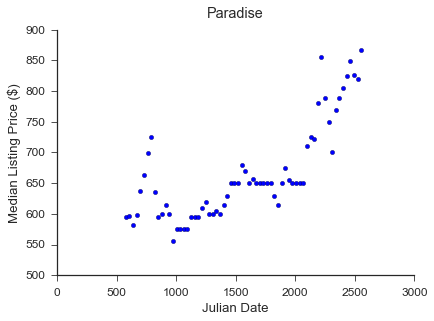

In [83]:
plt.title(names[1]['RegionName'], y = 1.03) #make a title that is the neighborhood price history
plt.scatter(ts['time'],ts[1]) #scatter the pricing trends
plt.xlabel('Julian Date')
plt.ylabel('Median Listing Price ($)')
sns.despine() # make the plot pretty

Just to see what we are doing here, let's look at all the neighborhoods pricing history on one plot

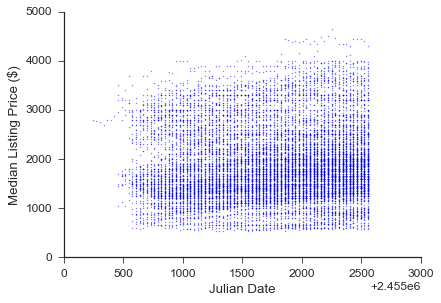

In [13]:
for i in range(len(ts.T) - 1):
    plt.scatter(ts['time'],ts[i], lw = 0, s = 2, alpha = 0.5) #scatter the pricing trends
    
plt.xlabel('Julian Date')
plt.ylabel('Median Listing Price ($)')
sns.despine() # make the plot pretty

The boundaries for all of the neighborhoods can be found here: http://www.zillow.com/howto/api/neighborhood-boundaries.htm

Let's compute some stats for each neighborhood. Stuff we would be interested in includes:

1) Median Price 
2) Price Linear Trend 
3) Price Linearity Value 

In [45]:
import statsmodels.api as smf #import statsmodels

In [138]:
lin_trend = [] #create an empty array to store information about our linear fits

for i in range(len(tnames) - 1): # for every 'hood
    
    mean_price = np.mean(ts[i]) #calculate a mean price, for starters
    
    #create a clean little DataFrame for fitting our line with statsmodels.
    f = ts[['time', i]].dropna().rename(columns = {i: 'price'}).apply(pd.to_numeric, errors = 'coerce')
    
    #create some input arrays for statsmodels, for whatever reason it is not liking working with Dataframes
    y = np.array(f['time'])
    X = np.array(f['price'])
    Xc = smf.add_constant(X)
    
    lin = smf.OLS(y,Xc).fit() #actually do the fit, price = a_1*time + a_2
    
    lin_trend.append(np.hstack((mean_price,lin.params,lin.bse,lin.rsquared,lin.nobs))) #add our results into an array

l = pd.DataFrame(lin_trend) #create a tidy little dataframe out of this linear fit data

#let's give this new dataframe some intelligible column names
l.rename(columns = {0: 'mean_price', 1:'intercept', 2: 'price_trend',3:'intercept_err', 4: 'price_trend_err', 5: 'rsquared', 6: 'nobs'}, inplace = True)

Let's examine our dataframe of linear fit characteristics for every neighborhood

In [171]:
l.head()

,mean_price,intercept,price_trend,intercept_err,price_trend_err,rsquared,nobs
0,812.052632,3294.506335,-1.248803,603.767608,0.742079,0.142798,19
1,665.416667,-2219.442536,5.688262,385.800108,0.575727,0.604003,66
2,3024.980519,-8687.812320,3.334284,504.989575,0.166625,0.842248,77
3,1421.232759,-3112.823098,3.377428,281.928792,0.197439,0.839367,58
4,2593.069231,-7257.726009,3.408531,536.303717,0.206473,0.812236,65


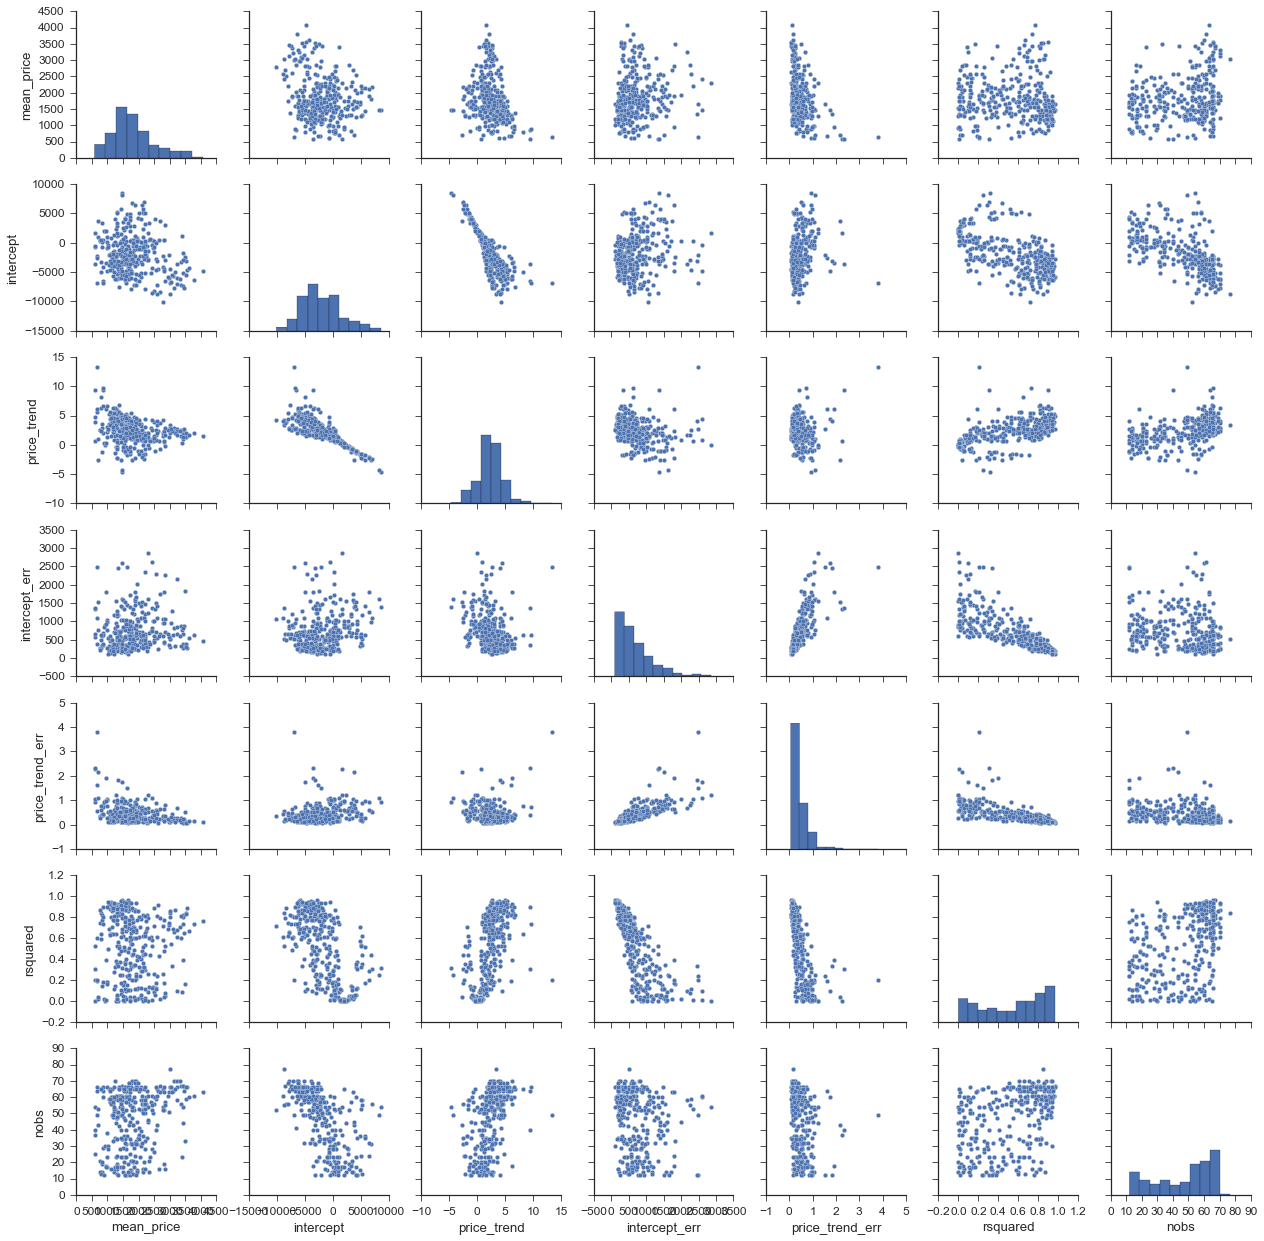

In [172]:
sns.pairplot(l)

Looking at the above plot, we can see a few things:

     (1) The more observations that a given 'hood has, the more positive its price trend
     (2) The intercepts and price trend obey an obvious relationship dictated by the fitting. I have included the intercept mainly so that we can reproduce the price at a given moment in time.

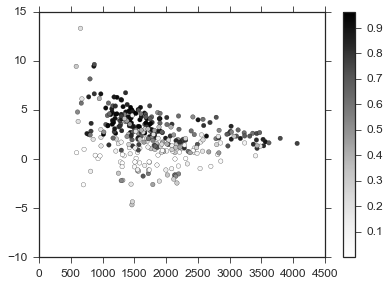

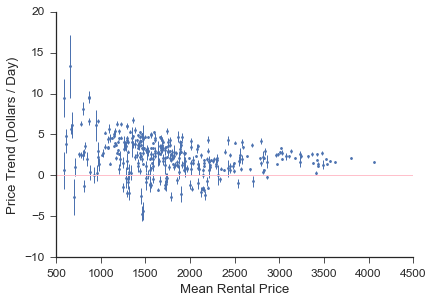

In [170]:
plt.figure()
plt.scatter(l['mean_price'],l['price_trend'], c = l['rsquared'])
plt.colorbar()

plt.figure()
plt.errorbar(l['mean_price'],l['price_trend'], l['price_trend_err'],fmt = '.', lw = 1)
plt.axhline(0, lw = 1, c = 'pink')
plt.xlabel('Mean Rental Price')
plt.ylabel('Price Trend (Dollars / Day)')
sns.despine()

Let's check out the dataset and see what's going on